In [1]:
import os, glob
from sklearn import preprocessing
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
dataset_path = os.getcwd() + '/orl_faces/'

In [3]:
def plot_portraits(images, titles, h, w, n_row, n_col):
    plt.figure(figsize=(2.2 * n_col, 2.2 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.20)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i])
        plt.xticks(())
        plt.yticks(())

In [4]:
total_images = 0
shape = None
for images in glob.glob(dataset_path + '/**', recursive=True):
    if images[-3:] == 'pgm' or images[-3:] == 'jpg':
        total_images += 1

print(total_images)

400


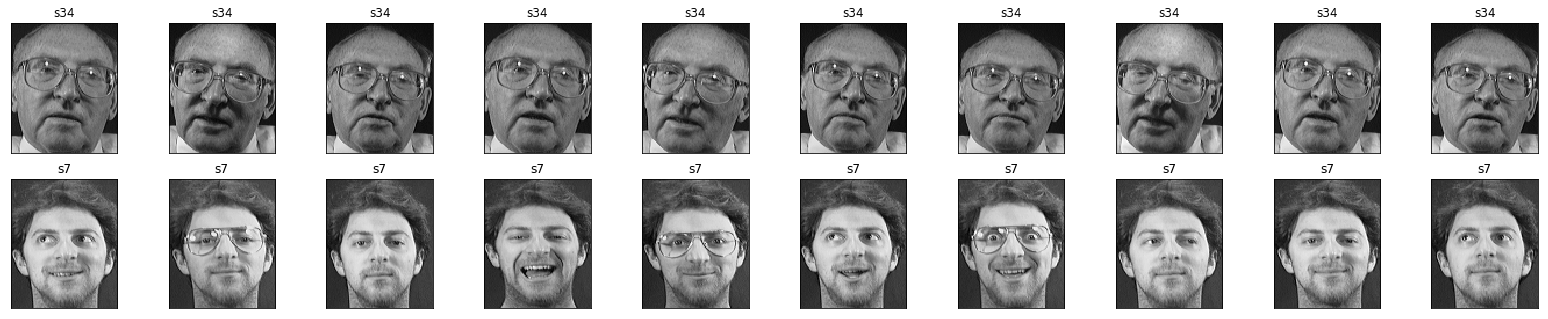

In [5]:
shape = (112,92)
all_images = np.zeros((total_images, shape[0], shape[1]) ,dtype='float64')
names = list()
i = 0
for folder in glob.glob(dataset_path + '/*'):
    for _ in range(10):
        names.append(folder[-3:].replace('/', ''))
    for image in glob.glob(folder + '/*'):
        read_image = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
        resized_image = cv2.resize(read_image, (shape[1], shape[0])) #cv2.resize resizes an image into (# column x # height)
        all_images[i] = np.array(resized_image)
        i += 1
plot_portraits(all_images, names, 112,92, 2, 10)

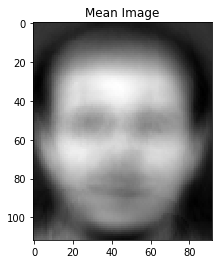

In [6]:
A = np.resize(all_images, (total_images, shape[0]*shape[1])) #convert the images into vectors
# image_back = np.reshape(vectorized[398], (112,92))
# plt.imshow(image_back)
# plt.show()
mean_vector = np.sum(A, axis=0, dtype='float64')/total_images 
mean_matrix = np.tile(mean_vector, (400, 1))
A_tilde = A - mean_matrix #mean-subtracted image vectors
plt.imshow(np.resize(mean_vector, (112,92)), cmap='gray')
plt.title('Mean Image')
plt.show()

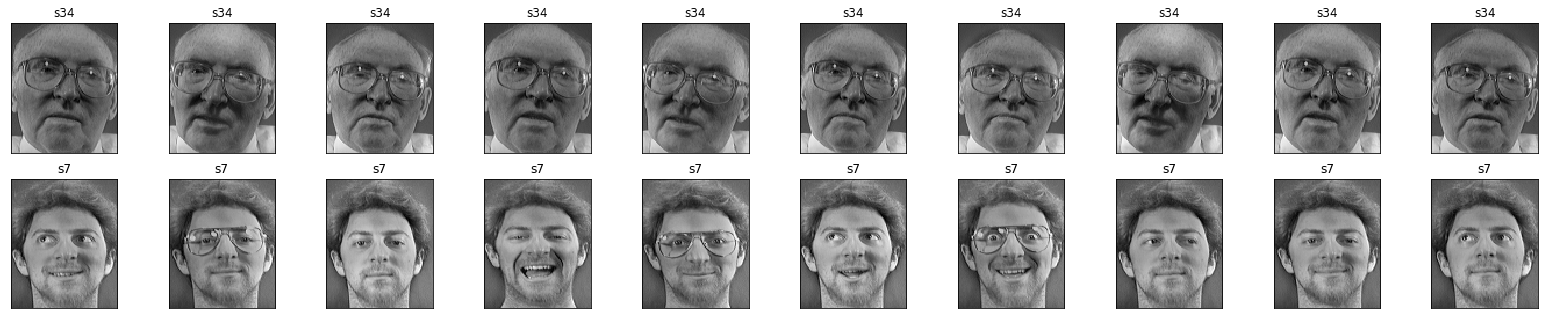

In [7]:
plot_portraits(A_tilde, names, 112,92, 2, 10) # matrix A_tilde that contains vectors of each mean subtracted img

In [8]:
L = (A_tilde.dot(A_tilde.T))/total_images
print("L shape : ", L.shape)
eigenvalues, eigenvectors = np.linalg.eig(L)
idx = eigenvalues.argsort()[::-1]
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx] #sorted eigenvalues and eigenvectors in descending order

L shape :  (400, 400)


In [9]:
print(A_tilde.shape) #each row is a vector of mean subtracted image

(400, 10304)


In [10]:
eigenvectors_C = A_tilde.T @ eigenvectors #linear combination of each column of A_tilde
eigenvectors_C.shape #each column is an eigenvector of C 

(10304, 400)

In [11]:
eigenfaces = preprocessing.normalize(eigenvectors_C.T) #normalize only accepts matrix with n_samples, n_feature. Hence the transpose
eigenfaces.shape

(400, 10304)

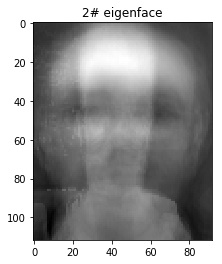

In [12]:
eigenface_index = 1
plt.imshow(np.reshape(eigenfaces[eigenface_index], (112,92)), cmap='gray')
plt.title(str(eigenface_index+1) + "# eigenface")
plt.show()

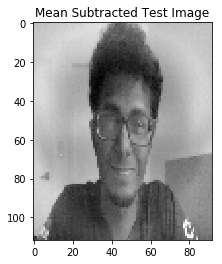

In [13]:
test_img = cv2.imread('test.jpg', cv2.IMREAD_GRAYSCALE)
test_img = cv2.resize(test_img, (92,112))
mean_subracted_testimg = np.reshape(test_img, (test_img.shape[0]*test_img.shape[1])) - mean_vector
plt.imshow(np.reshape(mean_subracted_testimg, (112,92)), cmap='gray')
plt.title("Mean Subtracted Test Image")
plt.show()

In [14]:
q = 300
projected_weights = eigenfaces[:q].dot(mean_subracted_testimg)
projected_weights.shape

(300,)

In [15]:
reconstructed = eigenfaces[:q].T.dot(projected_weights) #image reconstructed using 400 eigenfaces.
reconstructed.shape

(10304,)

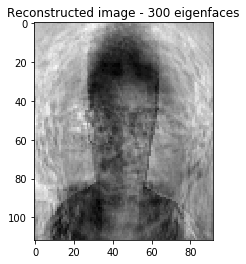

In [16]:
plt.imshow(np.reshape(reconstructed, (112,92)), cmap='gray')
plt.title("Reconstructed image - "+str(q)+" eigenfaces")
plt.show()

In [17]:
smallest_value = None
index = None
for k in range(total_images):
    x_projected = eigenfaces[:q].dot(A_tilde[k])
    diff = projected_weights - x_projected
    epsilon_k = math.sqrt(diff.dot(diff))
    if smallest_value == None:
        smallest_value = epsilon_k
        index = k
    if smallest_value > epsilon_k:
        smallest_value = epsilon_k
        index = k
        
if smallest_value < 2000:
    print(smallest_value, names[index])
else:
    print(smallest_value, "Unknown Face!")

4897.710289610018 Unknown Face!
